In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse as RMSE
import scipy.stats as stats
import numbers
import pickle


## Modelling
Modelling requires several different operations. For ease of repetition, I decided to make functions for these operations, with different options for each which could even be used together.    
The different operations and their functions are:     
 - Transform the Data
  - polynom
  - log
  - minmax_plus
  - norm
  - ohe
 - Feature Selection
  - simple_selector
  - stepwise_selector
  - rfe_selector
 - Handling Multicollinearity
  - multicoll_remove
 - Create the Model
  - model
 - Measuring Results
  - metrics

### polynom
This function creates polynomial columns for the features passed in as to_poly. If poly is 'all' it also creates columns for multiplications between the columns passed in. Lastly, though it gets column names from poly.get_feature_names, these have to be altered to make it readable by statsmodels' ols function.

In [273]:
def polynom(data_t, to_poly, poly='all'):
    poly_order = 2
    if poly == 'all':
        poly=PF(poly_order)
        data_poly = poly.fit_transform(data_t[to_poly])
        data_poly = pd.DataFrame(data_poly)
        data_poly.columns = poly.get_feature_names(data_t[to_poly].columns)
        data_t = pd.concat([data_t.drop(to_poly, axis=1),
                            data_poly.drop('1',axis=1)], axis=1)
        data_t.rename(lambda col: col.replace('.0', '').replace(' ','__')
                  .replace('^','_pow_'), axis=1, inplace=True)
    elif poly == 'singles':
        for feat in to_poly:
            df = pd.DataFrame(data_t[feat])
            print(feat)
            poly=PF(poly_order)
            data_poly = poly.fit_transform(df)
            data_poly = pd.DataFrame(data_poly)
            data_poly.columns = ['drop', feat, feat + '_squared']
            data_t = pd.concat([data_t.drop(feat, axis=1), 
                                data_poly.drop('drop',axis=1)], axis=1)
    return data_t 


### log
log simply replaces the data with the log of the data for the columns passed in as to_log

In [239]:
def log(data_t, to_log):
    for feat in to_log:
        data_t[feat] = data_t[feat].map(lambda x: np.log(x) if x!=0 else 0)
        #Note 'if' included so that 0 values wouldn't error, will still error
        #...between 0 and 1. Also, implies that the original 0 value was a 1
        #...but as these are around values of 100s, 1000s, the effect is minimal
    return data_t 


### norm
For each column in to_norm, if this isn't the test data, norm calculates its mean and stdev, using them to normalise the column's values. It then records the statistics used for each column so they can be used later for the test data.   
If this is test data (test=True) it reads the stats from the record made previously

In [238]:
def norm(data_t, to_norm, test=False):
    stats = {}
    if test:
        with open('norm_stats.pickle', 'rb') as f:
            stats = pickle.load(f)
    for feat in to_norm:
        ft = data_t[feat]
        if test:
            mean = stats[feat][0]
            stdev = stats[feat][1]
        else:
            mean = np.mean(ft)
            stdev = np.sqrt(np.var(ft))
        data_t[feat] = (ft-mean) / stdev
        stats[feat] = [mean, stdev]
    with open('norm_stats.pickle', 'wb') as f:
        pickle.dump(stats, f)
    return data_t 


### minmax_plus
This function performs min-max scaling on the columns in to_minmax, and also  multiplies by 100, and adds 1 to,each value to make them log-able. It records the stats used for the train-data and reads it for test-data, in the same way as norm.

In [272]:
def minmax_plus(data_t, to_minmax, test=False):
    stats = {}
    if test:
        with open('minmax_stats.pickle', 'rb') as f:
            stats = pickle.load(f)
    for feat in to_minmax:
        ft = data_t[feat]
        if test:
            min_ = stats[feat][0]
            max_ = stats[feat][1]
        else:
            min_ = ft.min()
            max_ = ft.max()
        data_t[feat] = 1 + 100*(ft-min_)/(max_-min_)
        stats[feat] = [min_, max_]
    with open('minmax_stats.pickle', 'wb') as f:
        pickle.dump(stats, f)
    return data_t 


### ohe
ohe gets dummies for the columns in to_ohe, drops the original, and adds these columns to the dataframe. Lastly, the column names have to be altered to make it readable by statsmodels' ols function.

In [237]:
def ohe(data_t, to_ohe):
    for feat in to_ohe:
        dummies = pd.get_dummies(data=data_t[feat], prefix=feat, prefix_sep='_',
                                drop_first=True)
        data_t.drop(feat, axis=1, inplace=True)
        data_t = pd.concat([data_t, dummies], axis=1)
    data_t.rename(lambda col: col.replace('.0', '').replace(' ','__')
                  .replace('^','_pow_'),
                  axis=1, inplace=True)
    return data_t 


### bin_latlong
Calculates (or looks up if it's test data) 5 equal divisions in each of lat and long. Then, for each row, it uses floor division by the bin size to calculate which bin the lat-long belongs in. The bin number increases by latitude first and then by longitude.

In [418]:
def bin_latlong(data_t, test=False):
    
    if not test:
        max_lat = data_t['lat'].max()
        min_lat = data_t['lat'].min()
        x=(max_lat - min_lat)/5

        max_long = data_t['long'].max()
        min_long = data_t['long'].min()
        y=(max_long - min_long)/5
        latlong_vals = [x, min_lat, y, min_long]
        
        with open('latlong_vals.pickle', 'wb') as f:
            pickle.dump(latlong_vals, f)
    else:
        with open('latlong_vals.pickle', 'rb') as f:
            latlong_vals = pickle.load(f)
        x = latlong_vals[0]
        min_lat = latlong_vals[1]
        y = latlong_vals[2]
        min_long = latlong_vals[3]
    
    data_t.loc[:,'lat_long'] = data_t.apply(lambda x: (x.lat-min_lat)//x
                                      + 5*(x.long-min_long)//y, axis=1)
    return data_t

### simple_selector
simple_selector starts by calling the model function, returning a model using all the features in x_cols. Only the features in x_cols with a pvalue lower than or equal to alpha are kept and returned.

In [301]:
def simple_selector(data_s, x_cols, alpha=0.05):
    
    results = model(data_s, x_cols)
    pv = pd.DataFrame(results.pvalues).drop('Intercept')
    pv.rename(columns={0:'p_value'}, inplace=True)
    x_cols = list(pv[pv.p_value <= alpha].index)
    
    return x_cols

### stepwise_selector
In this function loops adding or removing features depending on their pvalue each iteration; breaking out of the loop when stable.

In [302]:
def stepwise_selector(data_s, 
                       x_cols=[], 
                       alpha=0.05, 
                       verbose=False):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        x_cols - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    X = data_s[x_cols]
    y = data_s['price']
    threshold_in = alpha - 0.02
    threshold_out = alpha + 0.02
    included = list(x_cols)
    while True:
        print(len(included))
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            results = sm.OLS(y, sm.add_constant
                             (pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = results.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        results = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = results.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, 
                                                             worst_pval))
        if not changed:
            break
            
    return included

### rfe_selector
Here features are selected using sklearn's recursive-feature-elimination function for a range of numbers-of-features. Models are created for each set of features and the adjusted r-squared is plotted against the number of features. Using this graph, and the list of results, you can choose how many features you want to select. Enter this number when asked and it will call this function again. But this time specifying the number of features to select and returning with the selected features.     
Note: tried using mpld3 to show y-values when hovering over markers but couldn't get the graph to appear before asking for input.

In [300]:
def rfe_selector(data_s, x_cols, nfts=None):
    X = data_s[x_cols]
    y = data_s[outcome]
    linreg = LR()
    r2_adj = []
    
    n = nfts or 1
    n_max = min(len(x_cols), 80)
    r = range(n, n_max+1)
    while n <= n_max:
   
        selector = RFE(linreg, n_features_to_select=n)
        results = selector.fit(X, y)

        new_cols = []
        for i in range(len(x_cols)):
            if results.support_[i]:
                new_cols.append(x_cols[i])
        
        results = model(data_s, new_cols)
        r2_adj.append(results.rsquared_adj)
        if nfts:
            return new_cols
        n+=1
    print(list(zip(r, r2_adj)))
    fig, ax = plt.subplots()
    lines = ax.plot(r, r2_adj, marker='o')
    plt.show(block=False)
    
    
    print('Select number of features')
    choice = int(input())
    new_cols = rfe_selector(data_s, x_cols, nfts=choice)
    
    return new_cols

### Multicoll_remove    
This function removes a feature from each pair with high multicollinearity    
This function takes in the data, x_cols and the threshold for removing a feature

- create a dataframe of the correlation of the features in x_cols   
- transform this to get a list of pairs of features with high multicollinearity
- for each pair: check whether they are the same feature or if one of the features has already been listed to be removed; if so, continue to next pair 
- otherwise add the feature with the higher p-value to a list    
- remove the features in this list from x_cols    


return x_cols     




In [332]:
def multicoll_remove(data_mr, x_cols, multicollinearity_threshold):
    
    pvalues = model(data_mr, x_cols).pvalues
    corr = data_mr[x_cols].corr().abs().stack().reset_index().sort_values(0,
                                                            ascending = False)
    corr['pairs'] = list(zip(corr.level_0, corr.level_1))
    corr = corr.set_index('pairs').drop(['level_0', 'level_1'], axis=1)
    corr.columns = ['cc']
    corr = corr[corr.cc > multicollinearity_threshold]        

    to_drop = []
    for f0, f1 in corr.index:
        if (f0 == f1) | any(feat in [f0, f1] for feat in to_drop):
            continue
        to_drop.append(pvalues.loc[[f0, f1]]
                       .sort_values(ascending=False).index[0])
    x_cols = list(set(x_cols) - set(to_drop))
    return x_cols   

### metrics
metrics creates two graphs:
- a qqplot
- a residuals plot for homoscedasticity

In [291]:
def metrics(data_m, results, x_cols):
#     X = data[x_cols]
#     y = data.price
#     to_pred = pd.concat([y,X], axis=1)
#     yhat = results.predict(to_pred)
#     rmse = RMSE(y, yhat)
    
#     linreg = LR()
#     linreg.fit(X,y)
#     cv  = np.mean(CVS(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
#     rmse = (-cv)**0.5
      
#     print(f'RMSE: {rmse}')
    print(f'Number of features: {len(x_cols)}')
    fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45',
                             fit=True, alpha=0.1)

    fig = plt.figure(figsize=(12,12))
    plt.scatter(data_m.price, results.resid, alpha=0.5);
    plt.hlines(0, xmax=data_m.price.max(), xmin=data_m.price.min());    

## model
A small function to create a model using statsmodels' OLS function

In [281]:
def model(data_m, x_cols):
    
    predictors = '+'.join(x_cols)
    f = outcome + '~' + predictors
    results = ols(formula=f, data=data_m).fit()
    return results

In [ ]:
data_t = None


# Body

## Load and Split:

In [317]:
data = pd.read_csv('data/clean.csv')
data = data[data.price < 3000000]

data.sort_index(axis=1, inplace=True)
data_train, data_test = tts(data, train_size=0.8, random_state=111)
data_train = data_train.reset_index().drop('index', axis=1)



##  Modelling

Initial model using only cleaned data:

Number of features: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     2230.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:43:02   Log-Likelihood:            -2.2872e+05
No. Observations:               16946   AIC:                         4.575e+05
Df Residuals:                   16926   BIC:                         4.576e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.818e+06    2.9e+06      2.006      0.045    1.34e+05    1.15e+07
bathroomsx4    8736.8665    812.736     10.750      0.000    7143.820    1.03e+04
bedrooms      -2.932e+04   1960.694    -14.955      0.000   -3.32e+04   -2.55e+04
condition      2.977e+04   2329.336     12.779      0.000    2.52e+04    3.43e+04
date            107.7158     12.014      8.966      0.000      84.166     131.265
floorsx2       7870.6731   1812.257      4.343      0.000    4318.461    1.14e+04
grade              1e+05   2162.964     46.248      0.000    9.58e+04    1.04e+05
lat             5.98e+05   1.07e+04     55.903      0.000    5.77e+05    6.19e+05
long          -1.775e+05   1.33e+04    -13.353      0.000   -2.04e+05   -1.51e+05
sqft_above       51.6257     17.495      2.951      0.003      17.334      85.917
sqft_basement    30.0186     17.299      1.735      0.083      -3.889      63.926
sqft_living      91.0706     17.484      5.209      0.000      56.801     125.341
sqft_living15    41.8607      3.471     12.061      0.000      35.057      48.664
sqft_lot          0.1342      0.062      2.158      0.031       0.012       0.256
sqft_lot15       -1.2792      0.174     -7.367      0.000      -1.620      -0.939
view           5.074e+04   2141.114     23.697      0.000    4.65e+04    5.49e+04
waterfront     4.407e+05   1.86e+04     23.733      0.000    4.04e+05    4.77e+05
yr_built      -3207.2000    123.388    -25.993      0.000   -3449.054   -2965.346
yr_renovated    684.4011    126.900      5.393      0.000     435.663     933.139
zipcode        -527.1895     32.479    -16.231      0.000    -590.853    -463.526
==============================================================================
Omnibus:                     8137.022   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           103871.382
Skew:                           1.985   Prob(JB):                         0.00
Kurtosis:                      14.461   Cond. No.                     2.13e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

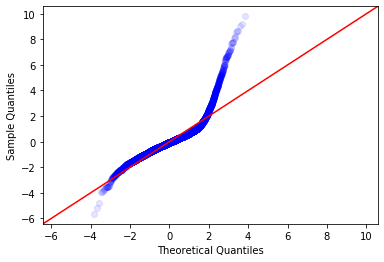

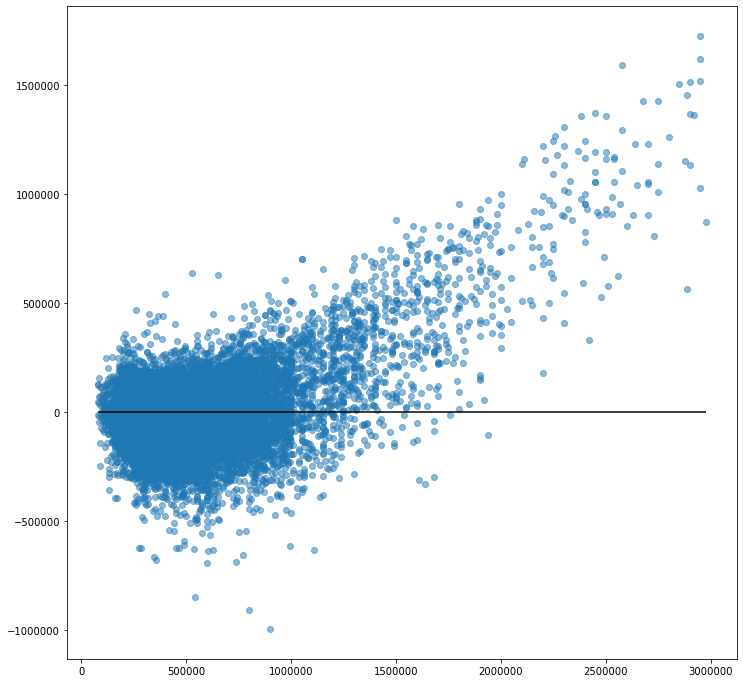

In [292]:
outcome = 'price'
x_cols = data_train.drop([outcome], axis=1).columns

results = model(data_train, x_cols)

metrics(data_train, results, x_cols)
results.summary()

Number of features: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     2353.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:52:08   Log-Likelihood:            -2.2872e+05
No. Observations:               16946   AIC:                         4.575e+05
Df Residuals:                   16927   BIC:                         4.576e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.829e+06    2.9e+06      2.010      0.044    1.44e+05    1.15e+07
bathroomsx4    8719.1049    812.719     10.728      0.000    7126.090    1.03e+04
bedrooms      -2.933e+04   1960.806    -14.958      0.000   -3.32e+04   -2.55e+04
condition      2.973e+04   2329.396     12.765      0.000    2.52e+04    3.43e+04
date            107.9201     12.015      8.982      0.000      84.370     131.470
floorsx2       7893.7335   1812.316      4.356      0.000    4341.406    1.14e+04
grade              1e+05   2163.018     46.232      0.000    9.58e+04    1.04e+05
lat            5.981e+05   1.07e+04     55.911      0.000    5.77e+05    6.19e+05
long          -1.775e+05   1.33e+04    -13.352      0.000   -2.04e+05   -1.51e+05
sqft_above       22.2323      4.376      5.080      0.000      13.655      30.810
sqft_living     120.4074      4.458     27.009      0.000     111.669     129.146
sqft_living15    42.0141      3.470     12.108      0.000      35.213      48.816
sqft_lot          0.1352      0.062      2.174      0.030       0.013       0.257
sqft_lot15       -1.2833      0.174     -7.391      0.000      -1.624      -0.943
view           5.075e+04   2141.228     23.702      0.000    4.66e+04    5.49e+04
waterfront     4.408e+05   1.86e+04     23.736      0.000    4.04e+05    4.77e+05
yr_built      -3205.7660    123.393    -25.980      0.000   -3447.629   -2963.903
yr_renovated    683.7178    126.907      5.388      0.000     434.966     932.469
zipcode        -527.3554     32.481    -16.236      0.000    -591.022    -463.689
==============================================================================
Omnibus:                     8138.377   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           103949.571
Skew:                           1.985   Prob(JB):                         0.00
Kurtosis:                      14.465   Cond. No.                     2.13e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

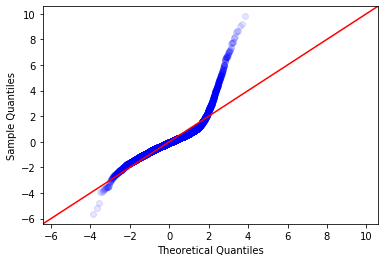

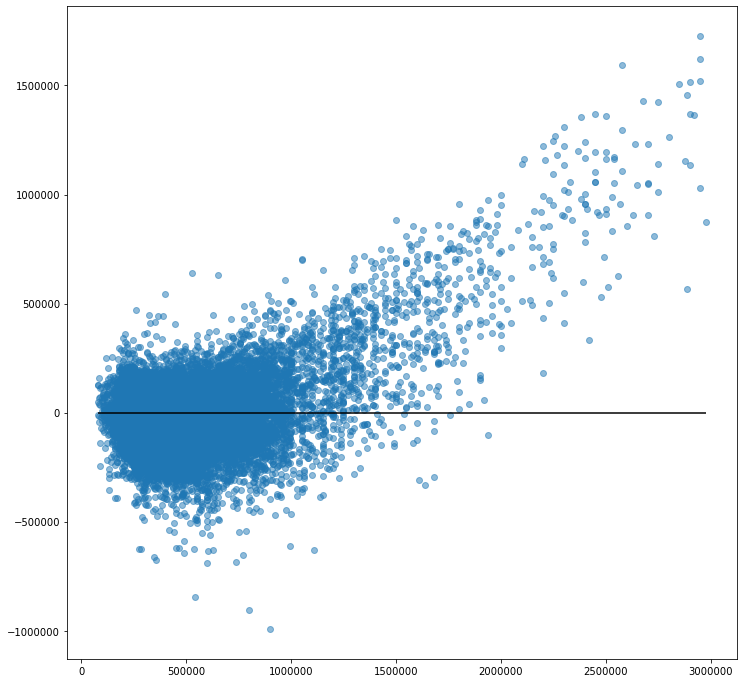

In [304]:
#simple feature selection
alpha=0.05
outcome = 'price'

data_t = data_train
x_cols = data_t.drop([outcome], axis=1).columns

x_cols = simple_selector(data_t, x_cols, alpha=alpha)

results = model(data_train, x_cols)
metrics(data_t, results, x_cols)
results.summary()

Number of features: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2488.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:18:29   Log-Likelihood:            -2.2988e+05
No. Observations:               16946   AIC:                         4.598e+05
Df Residuals:                   16931   BIC:                         4.599e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.254e+07   3.01e+06      7.495      0.000    1.66e+07    2.84e+07
long        -7.404e+04   1.38e+04     -5.381      0.000   -1.01e+05   -4.71e+04
lat          5.868e+05   1.14e+04     51.679      0.000    5.65e+05    6.09e+05
yr_built    -3229.2405     71.506    -45.160      0.000   -3369.400   -3089.081
sqft_lot15      0.1016      0.182      0.557      0.578      -0.256       0.459
bedrooms     6103.0559   1931.020      3.161      0.002    2318.056    9888.056
zipcode      -552.8571     34.575    -15.990      0.000    -620.627    -485.087
view          6.57e+04   2222.283     29.566      0.000    6.13e+04    7.01e+04
waterfront   4.278e+05   1.99e+04     21.548      0.000    3.89e+05    4.67e+05
grade         1.63e+05   1832.811     88.933      0.000    1.59e+05    1.67e+05
sqft_lot        0.1454      0.066      2.196      0.028       0.016       0.275
floorsx2     8471.8933   1724.295      4.913      0.000    5092.095    1.19e+04
date          111.6438     12.853      8.686      0.000      86.450     136.838
bathroomsx4  2.415e+04    767.973     31.452      0.000    2.26e+04    2.57e+04
condition    2.573e+04   2442.786     10.534      0.000    2.09e+04    3.05e+04
==============================================================================
Omnibus:                     8539.902   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           107477.008
Skew:                           2.121   Prob(JB):                         0.00
Kurtosis:                      14.585   Cond. No.                     2.06e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

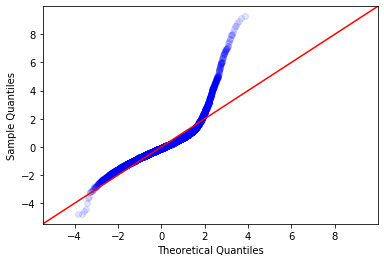

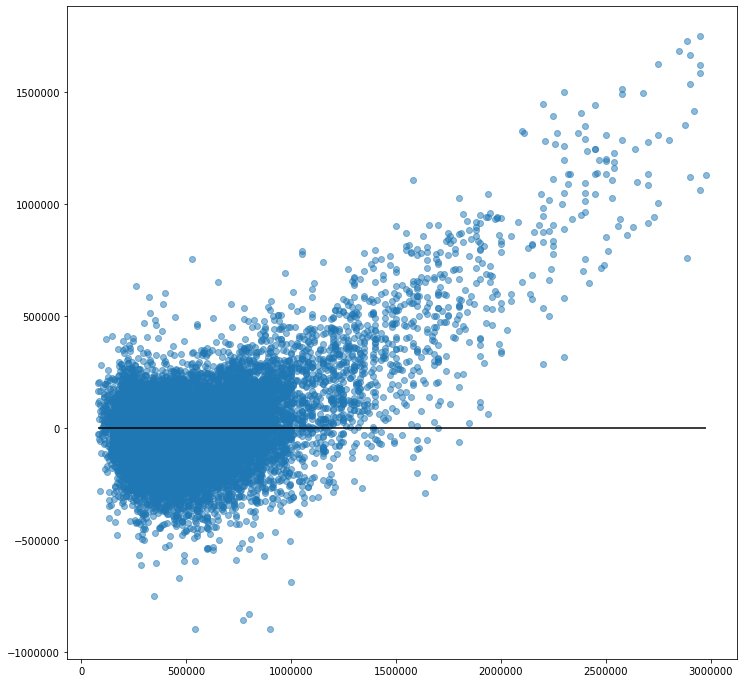

In [333]:
#simple feature selection with multicollinearity removal
multicollinearity_threshold=0.7
alpha=0.05
outcome = 'price'

data_t = data_train
x_cols = data_t.drop([outcome], axis=1).columns

x_cols = simple_selector(data_t, x_cols, alpha=alpha)
x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)

results = model(data_train, x_cols)
metrics(data_t, results, x_cols)
results.summary()

Number of features: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     2712.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:02:04   Log-Likelihood:            -2.2981e+05
No. Observations:               16946   AIC:                         4.596e+05
Df Residuals:                   16932   BIC:                         4.598e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.784e+07   2.98e+06      9.354      0.000     2.2e+07    3.37e+07
long          -4.897e+04   1.35e+04     -3.622      0.000   -7.55e+04   -2.25e+04
lat            5.739e+05   1.13e+04     50.674      0.000    5.52e+05    5.96e+05
yr_built      -3197.0393     70.653    -45.250      0.000   -3335.526   -3058.553
zipcode        -569.8914     34.405    -16.564      0.000    -637.329    -502.454
view           6.084e+04   2242.698     27.128      0.000    5.64e+04    6.52e+04
waterfront     4.355e+05   1.97e+04     22.062      0.000    3.97e+05    4.74e+05
grade          1.625e+05   1799.162     90.301      0.000    1.59e+05    1.66e+05
sqft_lot          0.1686      0.056      2.990      0.003       0.058       0.279
sqft_basement    50.5562      4.169     12.127      0.000      42.385      58.727
floorsx2       1.758e+04   1872.719      9.385      0.000    1.39e+04    2.12e+04
date            112.7514     12.800      8.808      0.000      87.661     137.842
bathroomsx4    2.139e+04    758.922     28.187      0.000    1.99e+04    2.29e+04
condition      2.348e+04   2439.158      9.625      0.000    1.87e+04    2.83e+04
==============================================================================
Omnibus:                     8631.476   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111524.391
Skew:                           2.142   Prob(JB):                         0.00
Kurtosis:                      14.815   Cond. No.                     2.04e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

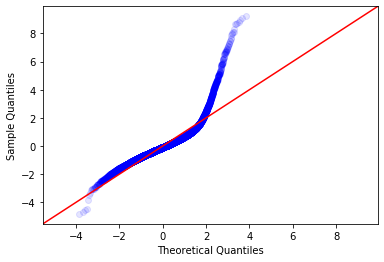

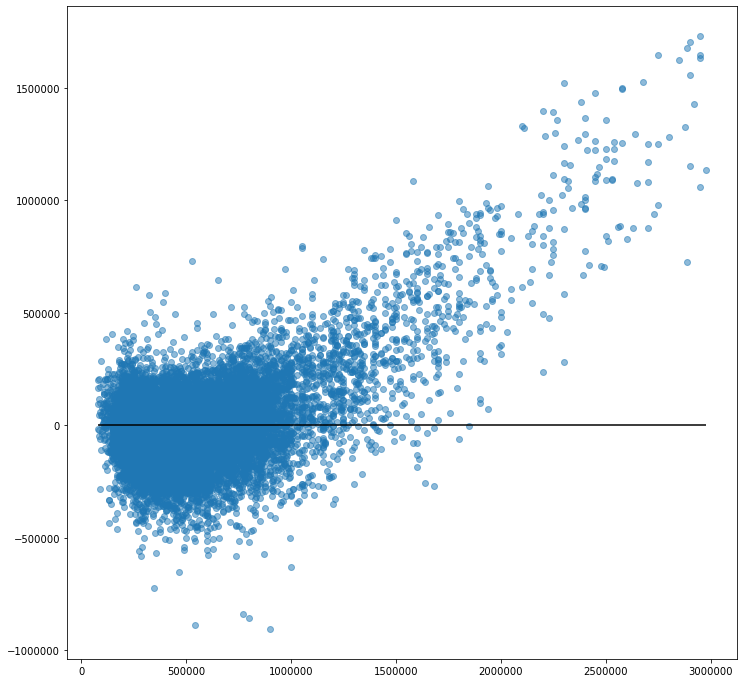

In [336]:
multicollinearity_threshold=0.7
alpha=0.05
outcome = 'price'

data_t = data_train
x_cols = data_t.drop([outcome], axis=1).columns


x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
x_cols = simple_selector(data_t, x_cols)

results = model(data_train, x_cols)
metrics(data_t, results, x_cols)
results.summary()

In [ ]:
to_poly = ['sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
to_log = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
to_norm = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
to_ohe = ['bedrooms', 'bathroomsx4','condition', 'floorsx2','grade','view']

multicollinearity_threshold=0.7
alpha=0.05
outcome = 'price'

# data_t = transform(data_train, poly='all')


x_cols = data_t.drop([outcome], axis=1).columns

x_cols x  = simple_selector(data_t, x_cols, alpha=alpha)

x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
x_cols = simple_selector(data_t, x_cols)

results = model(data_train, x_cols)

metrics(data_t, results, x_cols)
results.summary()


In [ ]:
data = pd.read_csv('data/clean.csv')
#data = data[data.price < 2000000]

data.sort_index(axis=1, inplace=True)
data_train, data_test = tts(data, train_size=0.8, random_state=111)
multicollinearity_threshold=0.7

#data_t = data.copy()
# data_t = transform(data_train)
data_train = data_train.reset_index().drop('index', axis=1)
data_train

In [ ]:
X = data_train.drop(outcome, axis=1)
pca = PCA(n_components = 6, whiten=True)
pca.fit(X)

In [ ]:
pca.components_

In [136]:
# def transform(data_t, poly=None, test=False):
#     """
#     poly values: 'all', 'list', 'singles', 'all_single'
#     Note: singles/all_single -column names only have first letters
    
#     """

#     poly_order = 2

#     if poly in ['all', 'all_single']:
#         to_poly = data_t.drop(to_ohe + ['price'], axis=1).columns
#         if poly == 'all':
#             poly = 'list'
#         elif poly == 'all_single':
#             poly = 'singles'
#     if poly == 'list':
#         poly=PF(poly_order)
#         data_poly = poly.fit_transform(data_t[to_poly])
#         data_poly = pd.DataFrame(data_poly)
#         data_poly.columns = poly.get_feature_names(data_t[to_poly].columns)
#         data_t = pd.concat([data_t.drop(to_poly, axis=1),
#                             data_poly.drop('1',axis=1)], axis=1)
#     elif poly == 'singles':
#         for feat in to_poly:
#             df = pd.DataFrame(data_t[feat])
#             print(feat)
#             poly=PF(poly_order)
#             data_poly = poly.fit_transform(df)
#             data_poly = pd.DataFrame(data_poly)
#             data_poly.columns = ['drop', feat, feat + '_squared']
#             data_t = pd.concat([data_t.drop(feat, axis=1), 
#                                 data_poly.drop('drop',axis=1)], axis=1)

#     for feat in to_log:
#         data_t[feat] = data_t[feat].map(lambda x: np.log(x) if x!=0 else 0)

        
#     stats = {}
#     if test:
#         with open('norm_stats.pickle', 'rb') as f:
#             stats = pickle.load(f)
#     for feat in to_norm:
#         ft = data_t[feat]
#         if test:
#             mean = stats[feat][0]
#             stdev = stats[feat][1]
#         else:
#             mean = np.mean(ft)
#             stdev = np.sqrt(np.var(ft))
#         data_t[feat] = (ft-mean) / stdev
#         stats[feat] = [mean, stdev]
#     with open('norm_stats.pickle', 'wb') as f:
#         pickle.dump(stats, f)
        
        
#     for feat in to_ohe:
#         dummies = pd.get_dummies(data=data_t[feat], prefix=feat, prefix_sep='_',
#                                 drop_first=True)
#         data_t.drop(feat, axis=1, inplace=True)
#         data_t = pd.concat([data_t, dummies], axis=1)
#     data_t.rename(lambda col: col.replace('.0', '').replace(' ','__')
#                   .replace('^','_pow_'),
#                   axis=1, inplace=True)
    
#     return data_t 

